# Primeiro exemplo

Exemplo de código para análise de imagens do PAN-STARRS1

Este foi o primeiro teste desenvolvido para visualização das capacidades do código. Ferramentas melhores estão sendo desenvolvidas em paralelo.

In [1]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astropy.wcs import WCS
from astroquery.imcce import Skybot
from astroquery.vizier import Vizier
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.animation import FuncAnimation
import matplotlib
from regions import Regions

In [2]:
lista = glob.glob('*.fits')
columns = ['RA_ICRS', 'DE_ICRS', 'pmRA', 'pmDE']
epoch = Time('J2016.0', scale='tdb')

In [ ]:
def create_region(image_name):
    # Lê o header da imagem 
    header = fits.getheader(image_name)
    time = header['DATE-OBS']
    print(time)
    exp = header['EXPTIME']
    print(exp)
    naxis1 = int(header['NAXIS1'])
    naxis2 = int(header['NAXIS2'])
    cdelt = header['CDELT1']*u.deg/u.pix

    obstime = Time(time) + exp*u.s/2 # Calcula o instante da imagem
    w = WCS(header[0:30])  # Lê o World Coordinate System da imagem

    b1 = w.pixel_to_world(0,0)
    b2 = w.pixel_to_world(naxis1, naxis2)
    center = w.pixel_to_world(naxis1/2, naxis2/2)
    sep = b1.separation(b2)
    print(sep)

    w.wcs.crpix += np.array([57, -59])  # Offset manual para as imagens de teste

    # Faz a busca pelos asteroides conhecidos no SkyBot
    results = Skybot.cone_search(center, sep/1.8, obstime)
    asteroides = SkyCoord(ra=results['RA'], dec=results['DEC'])
    px, py = w.world_to_pixel(asteroides)
    px = np.array(px, ndmin=1)
    py = np.array(py, ndmin=1)
    unc = results['posunc']

    # Faz a busca pelas estrelas conhecidas no Vizier
    vquery = Vizier(timeout=600, row_limit=-1, columns=columns)
    result = vquery.query_region(center, radius=sep/1.8, catalog='I/355/gaiadr3', cache=False)[0]
    pmra = np.nan_to_num(result['pmRA'], 0)
    pmdec = np.nan_to_num(result['pmDE'], 0)
    stars = SkyCoord(ra=result['RA_ICRS'], dec=result['DE_ICRS'], pm_ra_cosdec=pmra, pm_dec=pmdec, obstime=epoch)
    obs_stars = stars.apply_space_motion(new_obstime=obstime)
    pxs, pys = w.world_to_pixel(obs_stars)
    pxs = np.array(pxs, ndmin=1)
    pys = np.array(pys, ndmin=1)

    # Escreve o arquivo .reg que contêm as localizações das estrelas e dos asteroides.
    f = open(image_name[:-4] + 'reg', 'w')
    for i in range(len(px)):
        f.write('image; circle( {}, {}, {}) # color=red width=2 text={{{}}}\n'.format(px[i], py[i], 5, results['Name'][i]))
        f.write('image; circle( {}, {}, {}) # color=red width=2 dash=1\n'.format(px[i], py[i], (unc[i]/cdelt).decompose().value))
    for i in range(len(pxs)):
        f.write('image; circle( {}, {}, {}) # color=green width=2\n'.format(pxs[i], pys[i], 5))
    f.close()

In [6]:
for l in lista:
    # print(l)
    create_region(l)

0d14m41.31370504s


c:\Users\max00\OneDrive\Área de Trabalho\AsteroidHunter\venv\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1129 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


0d14m41.31426658s


c:\Users\max00\OneDrive\Área de Trabalho\AsteroidHunter\venv\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1130 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


0d14m41.34335681s
0d14m41.33067322s


c:\Users\max00\OneDrive\Área de Trabalho\AsteroidHunter\venv\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1131 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


RuntimeError: SkyBoT comet conesearch -> MySQL server (asterws3.imcce.fr): 

Para visualizar a imagem com as regiões, é necessário utilizar o DS9, com o seguinte comando

ds9 {nome_da_imagem}.fits -region {nome_da_imagem}.reg

Caso tenha mais de uma imagem, basta fazer:

ds9 {nome_da_imagem1}.fits -region {nome_da_imagem1}.reg {nome_da_imagem2}.fits -region {nome_da_imagem2}.reg {nome_da_imagem3}.fits -region {nome_da_imagem3}.reg

c:\Users\max00\OneDrive\Área de Trabalho\AsteroidHunter\venv\Lib\site-packages\regions\shapes\circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


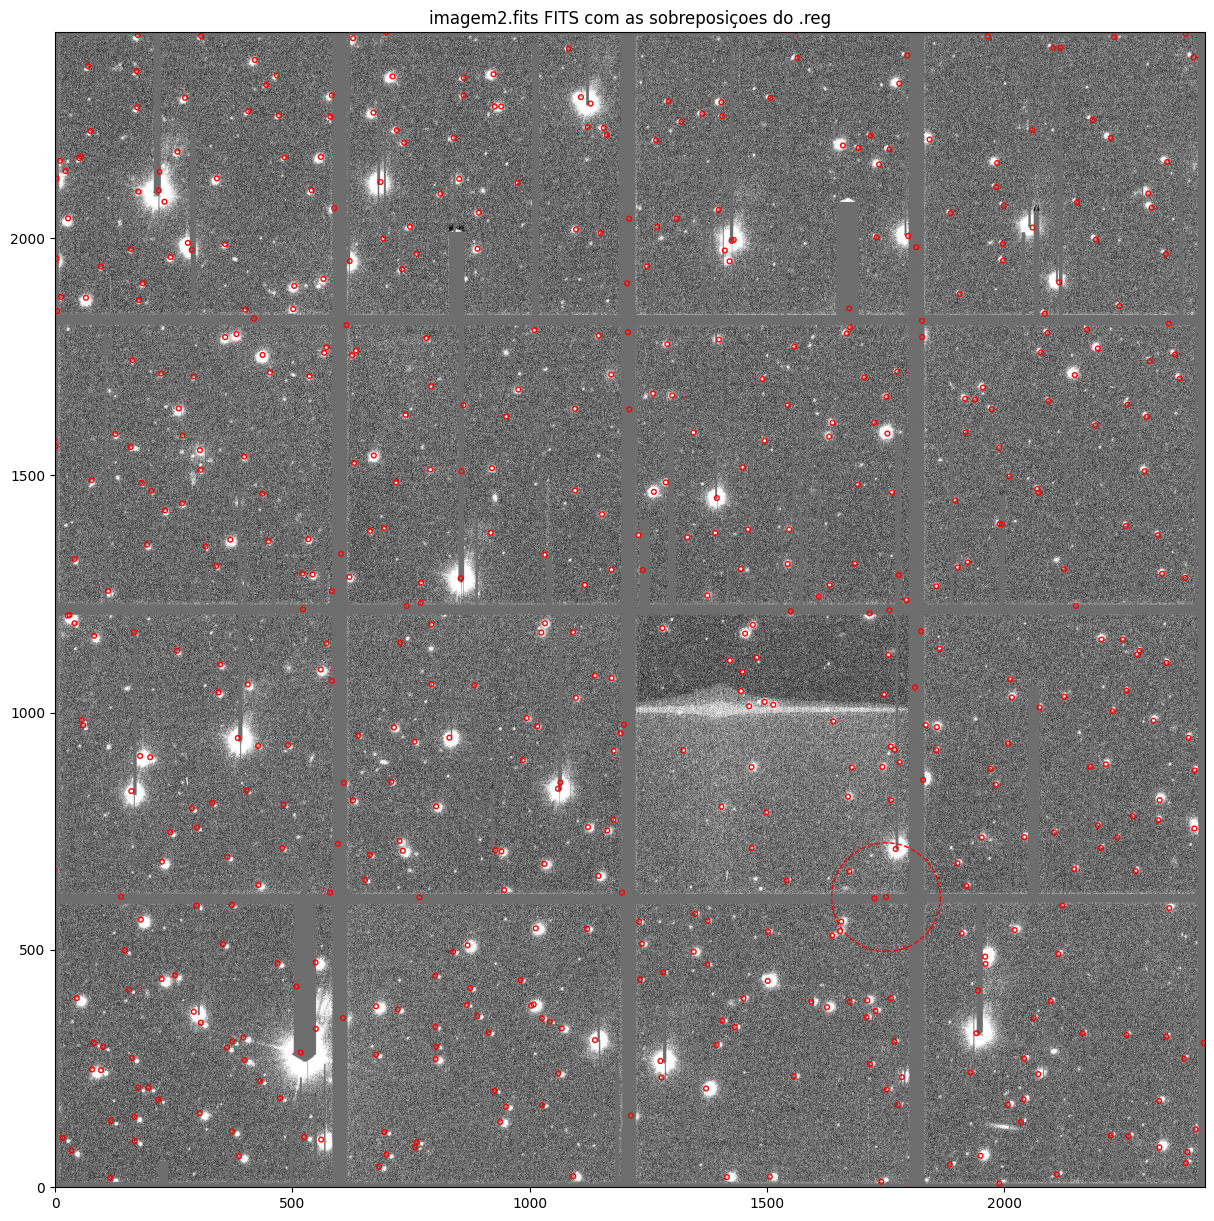

In [2]:
%matplotlib inline

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from regions import Regions

image_file = "imagem2.fits"
hdu = fits.open(image_file)
data = hdu[0].data  
# print(data) # so conferindo se os dados de pixel estao aqui mesmo 

# aqui eu uso a biblioteca regions para abrir o arquivo .reg e plotar junto com a imagem fits
regions = Regions.read('imagem2.reg', format='ds9')

# aqui to usando o matplot pra plotar a imagem fits
plt.figure(figsize=(15, 15))
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 2), vmax=np.percentile(data, 98))
plt.title(f"{image_file} FITS com as sobreposiçoes do .reg")

# pra cada infomraçao de coordenada de regiao no arquivo .reg eu vou iterar e desenhar um circulo
ax = plt.gca()
for region in regions:
    region.plot(ax=ax, color='red', lw=1) 

plt.show()


In [ ]:
matplotlib.use('TkAgg') # pra animaçoes dinamicas 

def load_fits(image_file):
    hdu = fits.open(image_file)
    return hdu[0].data 

def load_regions(region_file):
    return Regions.read(region_file, format='ds9')

image_files = ["imagem1.fits", "imagem2.fits", "imagem3.fits"]
reg_files = ["imagem1.reg", "imagem2.reg", "imagem3.reg"]


images = [load_fits(img) for img in image_files]
regions = [load_regions(reg) for reg in reg_files]

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')

img_plot = ax.imshow(images[0], cmap='gray', origin='lower', vmin=np.percentile(images[0], 2), vmax=np.percentile(images[0], 98))

def update(frame):
    img_plot.set_data(images[frame])
    
    ax.cla()
    
    ax.imshow(images[frame], cmap='gray', origin='lower', vmin=np.percentile(images[frame], 2), vmax=np.percentile(images[frame], 98))
    
    for region in regions[frame]:
        region.plot(ax=ax, color='red', lw=1)
    
    ax.set_title(f"Imagem {frame + 1}")
    
    return [img_plot]


animation = FuncAnimation(fig, update, frames=len(images), interval=500, repeat=True)
plt.tight_layout()
plt.show()

c:\Users\max00\OneDrive\Área de Trabalho\AsteroidHunter\venv\Lib\site-packages\regions\shapes\circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
